# $$H=-\underbrace{\sum^{N-1}_{i}\sum^{N}_{j>i} J_{ij}\sigma^{z}_{i}\sigma^{z}_{j}}_{H1}-\underbrace{\sum^{N}_{i}h_{i}\sigma^{x}_{i}}_{H2}$$


In [3]:
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from qiskit import *
from itertools import product
import random
from IPython.display import Image

In [4]:
def couplings(N):
    h , J = [], []
    for i in range(N):
        h.append(random.choice(range(1,2,2)))
    for j in range(N):
        J.append(random.choice(range(1,2,2))*0.5)
    return h,J

print("h=",couplings(6)[0],"\nJ=",couplings(6)[1])

h= [1, 1, 1, 1, 1, 1] 
J= [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [5]:
def param_trial(N):
    return(2*np.pi*np.random.rand(N*3))
print(repr(param_trial(3)))

array([5.08084342, 3.84364422, 1.79510696, 0.86880722, 5.51228894,
       5.35524914, 2.88233491, 1.7433246 , 4.21211053])


In [6]:
#If we want translational symmetry to be respected we have to apply the same angles 
#for every qubit
def param_trial_new(N,layers):
    param = []
    for i in range(layers):
        param1 = param_trial(1)
        for j in range(N):
            for k in range(len(param1)):
                param.append(param1[k]) 
    return(param)
print("param={}\n".format(param_trial_new(3,2)))

param=[0.331147254481702, 4.878570158122327, 4.557537874402517, 0.331147254481702, 4.878570158122327, 4.557537874402517, 0.331147254481702, 4.878570158122327, 4.557537874402517, 1.9579623480729509, 3.4558253930469145, 5.954071829227232, 1.9579623480729509, 3.4558253930469145, 5.954071829227232, 1.9579623480729509, 3.4558253930469145, 5.954071829227232]



In [7]:
def conv_qubitbook(counts):
    N = len(str(list(counts.items())[0][0]))
    #I did that so that I wont have to include another input to the function
    qubitbook = counts
    for i in qubit_list(N):
        if i not in qubitbook.keys():
            qubitbook[i] = 0
    return qubitbook

In [8]:
def qubit_list(Nqubit):
    li = ['0', '1']
    combs = [''.join(comb) for comb in product(li, repeat = Nqubit)]
    return combs
print(qubit_list(3))

['000', '001', '010', '011', '100', '101', '110', '111']


#  <center> <font color ='#4d4dff' size="10"> Respecting traslation Symmetry

In [9]:
# For Periodic Boundary Conditions:
def circuit_PBC(N,param,layers):
    qr = QuantumRegister(N)
    cr = ClassicalRegister(N)
    qc = QuantumCircuit(qr, cr)
    #param4
#   Momentum eigenstate
#     qc.x(qr[0])
#     [qc.cx(qr[i],qr[i+1]) for i in range(N-1)]
#     qc.barrier()
    for l in range(layers):
        for i in range(N):
            qc.rx(param[3*i+3*N*l],qr[i])
            qc.ry(param[3*i+3*N*l+1],qr[i])
            qc.rz(param[3*i+3*N*l+2],qr[i])
        [qc.rzz(np.pi/3,qr[i],qr[i+1]) for i in range(N-1)]
        if N!=1:
            qc.rzz(np.pi/3,qr[N-1],qr[0])
        qc.barrier()
    qc.unitary
    [qc.measure(qr[i], cr[i]) for i in range(N)]
    return qc

param2=[2.1898214735695793, 4.29062674016246, 4.4583847425275245, 2.1898214735695793, 4.29062674016246, 4.4583847425275245]


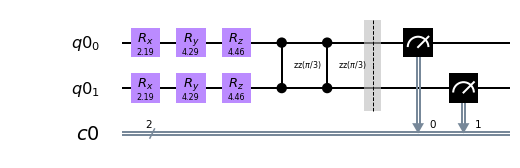

In [10]:
N=2
layers =1
param1 = param_trial_new(N,layers)
# param2 = [2.9, 6.09, 6.07,2.9, 6.09, 6.07, 2.9, 6.09, 6.07]
qc_PBC = circuit_PBC(N,param1,layers)
print("param2={}".format(repr(param1)))
qc_PBC.draw(output="mpl")

counts: {'00': 33, '10': 29, '11': 9, '01': 29}
new_counts: {'00': 33, '01': 29, '10': 29, '11': 9}
qubit list: ['00', '01', '10', '11']


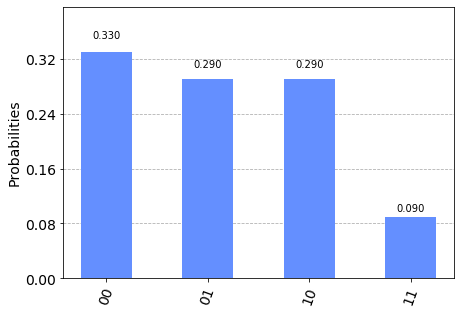

In [11]:
counts = execute(qc_PBC,Aer.get_backend('qasm_simulator'),shots = 100).result().get_counts()
print("counts:",counts)
counts = conv_qubitbook(counts)
counts = dict(sorted(counts.items()))
print("new_counts:",counts)
print("qubit list:",qubit_list(N))
plot_histogram(conv_qubitbook(counts))

In [12]:
# For Periodic Boundary Conditions:
def compute_H1_PBC(N,NUM_SHOTS,param,J,layers):
    H1=0
    a=[]
    qc = circuit_PBC(N,param,layers)
    job = execute(qc,Aer.get_backend('qasm_simulator'),shots=NUM_SHOTS)
    result = job.result()
    counts = result.get_counts()
    counts = conv_qubitbook(counts) 
    #adds the non-measured states to the list to complete the set of possible 2**N configurations
    counts = dict(sorted(counts.items())) #sorts the dictionary of counts according to their key
    [a.append([int(d) for d in str(list(counts)[i])]) for i in range(len(list(counts)))]
    #now for the periodic boundary condition:
    a.append(a[0])
    #print("len(a):",len(a))
    shots = sum(counts.values())
    P1 = [(i, c/shots) for i, c in counts.items()]
    #print("probs:",P1)
    for i in range(N-1): #runs over the N-1 pairs of consecutive qubits
        for j in range(2**N): #runs over the set of 2**N states
            if a[j][i]==a[j][i+1]:
                H1 += J[i]*P1[j][1]
            if a[j][i]!=a[j][i+1]:
                H1 -= J[i]*P1[j][1]
            if i==N-2:
                if a[j][N-2]==a[j][0]:
                    H1 += J[i]*P1[j][1]
                if a[j][N-2]!=a[j][0]:
                    H1 -= J[i]*P1[j][1]
#             print("state:'{}' (qubits:{} and {}) H1={}".format(P[j][0],i,i+1,H1))
    #print("H1 =",H1)
    return H1

In [13]:
NUM_SHOTS = 10000
N=3
layers = 2
param = param_trial(N*layers)
J = couplings(N)[1]
compute_H1_PBC(N,NUM_SHOTS,param,J,layers)

-0.27779999999999994

In [14]:
# For Periodic Boundary Conditions:
def circuit2_PBC(N,param,layers):
    qr = QuantumRegister(N)
    cr = ClassicalRegister(N)
    qc = QuantumCircuit(qr, cr)
#   Momentum eigenstate
#     qc.x(qr[0])
#     [qc.cx(qr[i],qr[i+1]) for i in range(N-1)]
#     qc.barrier()
    for l in range(layers):
        for i in range(N):
            qc.rx(param[3*i+3*N*l],qr[i])
            qc.ry(param[3*i+3*N*l+1],qr[i])
            qc.rz(param[3*i+3*N*l+2],qr[i])
        [qc.rzz(np.pi/3,qr[i],qr[i+1]) for i in range(N-1)]
        if N!=1:
            qc.rzz(np.pi/3,qr[N-1],qr[0])
        qc.barrier()
    [qc.h(qr[i]) for i in range(N)]
    qc.barrier()
    #qc.x(qr[1])
    #qc.x(qr[2])
    #qc.unitary
    [qc.measure(qr[i], cr[i]) for i in range(N)]
    return qc

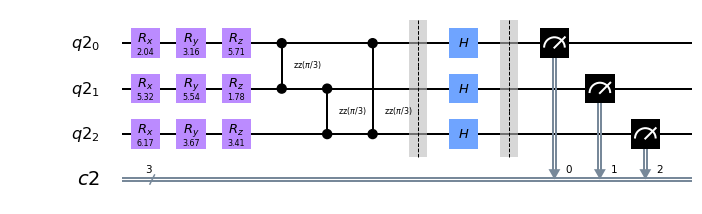

In [15]:
N=3
layers=1
param = param_trial(N*layers)
qc2 = circuit2_PBC(N,param,layers)
qc2.draw(output="mpl")

In [16]:
def compute_H2_PBC(N,NUM_SHOTS,param,h,layers):
    a2 = []
    H2 = 0
    qc2 = circuit2_PBC(N,param,layers)
    job2 = execute(qc2,Aer.get_backend('qasm_simulator'),shots=NUM_SHOTS)
    result2 = job2.result()
    counts2 = result2.get_counts()
    counts2 = conv_qubitbook(counts2)
    counts2 = dict(sorted(counts2.items())) #sorts the dictionary of counts according to their key
    [a2.append([int(d) for d in str(list(counts2)[i])]) for i in range(len(list(counts2)))]
    #print("counts after sorting:",counts)
    #split dictionary "count" keys into array elements
    #To account for the case where a register gives only one qubit with probability 1 after all shots
    shots2 = sum(counts2.values())
    P2 = [(i, c/shots2) for i, c in counts2.items()]
    #print("register[{}] a2={}".format(register,a2))
    #print("register[{}] P={}".format(register,P2))
    for i in range(N): #runs over the N qubits
        for j in range(2**N): #runs over the set of 2**N states
            if a2[j][i]==0:
                H2 += h[i]*P2[j][1]
            if a2[j][i]==1:
                H2 -= h[i]*P2[j][1]
    #print("H2 (i={},j={}):{}".format(i,j,H2))
    #print("H2 =",H2)
    return H2

In [17]:
NUM_SHOTS = 100000
N=10
layers = 2
param = param_trial(N*layers)
h = couplings(N)[0]
compute_H2_PBC(N,NUM_SHOTS,param,h,layers)

-0.29151999999999756

## <center> <font color ='#4d4d33' size="7"> Noisy Case

In [18]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
# a simple noise model, which randomly flips each bit in an output with probability 𝑝.
def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    return noise_model

# Lets try it:

         ┌─┐   
q4_0: |0>┤M├───
         └╥┘┌─┐
q4_1: |0>─╫─┤M├
          ║ └╥┘
 c4_0: 0 ═╩══╬═
             ║ 
 c4_1: 0 ════╩═
               
shorted_mitigated_counts:{'00': 10000, '01': 0, '10': 0, '11': 0}
shorted_noisy_counts:{'00': 2454, '01': 2532, '10': 2484, '11': 2530}


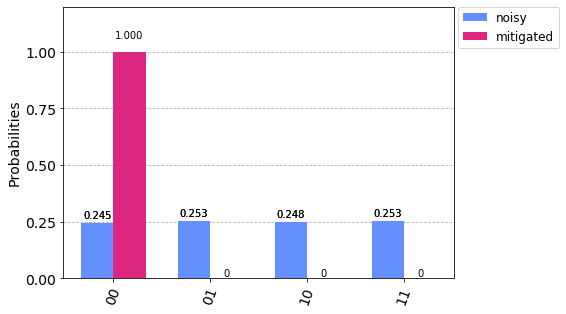

In [19]:
def simple_circuit(N):
    qr = QuantumRegister(N)
    cr = ClassicalRegister(N)
    qc = QuantumCircuit(qr, cr)
    [qc.measure(qr[i], cr[i]) for i in range(N)]
    return qc
N=2
qc = simple_circuit(N)
print(qc)
noise_model = get_noise(0.5)
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
mitigated_counts = execute(qc,Aer.get_backend('qasm_simulator'),shots = 10000).result().get_counts()
noisy_counts = execute(qc,Aer.get_backend('qasm_simulator'),shots = 10000, noise_model=noise_model).result().get_counts()
mitigated_counts = conv_qubitbook(mitigated_counts)
mitigated_counts = dict(sorted(mitigated_counts.items()))
noisy_counts = conv_qubitbook(noisy_counts)
noisy_counts = dict(sorted(noisy_counts.items()))
print("shorted_mitigated_counts:{}\nshorted_noisy_counts:{}".format(mitigated_counts,noisy_counts))
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

# And for the circuit of interest:

         ┌─────────┐┌──────────┐┌──────────┐                       ░ ┌─┐   
q5_0: |0>┤ Rx(2.9) ├┤ Ry(6.09) ├┤ Rz(6.07) ├─■──────────■──────────░─┤M├───
         ├─────────┤├──────────┤├──────────┤ │zz(pi/3)  │zz(pi/3)  ░ └╥┘┌─┐
q5_1: |0>┤ Rx(2.9) ├┤ Ry(6.09) ├┤ Rz(6.07) ├─■──────────■──────────░──╫─┤M├
         └─────────┘└──────────┘└──────────┘                       ░  ║ └╥┘
 c5_0: 0 ═════════════════════════════════════════════════════════════╩══╬═
                                                                         ║ 
 c5_1: 0 ════════════════════════════════════════════════════════════════╩═
                                                                           
shorted_mitigated_counts:{'00': 6, '01': 232, '10': 224, '11': 9538}
shorted_noisy_counts:{'00': 2431, '01': 2493, '10': 2555, '11': 2521}


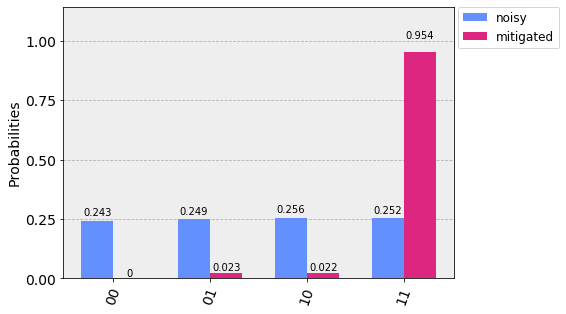

In [35]:
def trial_circuit(N,param,layers):
    qr = QuantumRegister(N)
    cr = ClassicalRegister(N)
    qc = QuantumCircuit(qr, cr)
    #   Momentum eigenstate
    # qc.x(qr[0])
    # [qc.cx(qr[i],qr[i+1]) for i in range(N-1)]
    #qc.barrier()
    for l in range(layers):
        for i in range(N):
            qc.rx(param[3*i+3*N*l],qr[i])
            qc.ry(param[3*i+3*N*l+1],qr[i])
            qc.rz(param[3*i+3*N*l+2],qr[i])    
        [qc.rzz(np.pi/3,qr[i],qr[i+1]) for i in range(N-1)]
        if N!=1:
            qc.rzz(np.pi/3,qr[N-1],qr[0])
        qc.barrier()
        [qc.measure(qr[i], cr[i]) for i in range(N)]
    return qc

# qc.barrier()
#qc.x(qr[1])
#qc.x(qr[2])
#qc.unitary

N=2
layers = 1
# param = param_trial_new(N,layers)
param = [2.9, 6.09, 6.07,2.9, 6.09, 6.07, 2.9, 6.09, 6.07]
qc = trial_circuit(N,param,layers)
print(qc)

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

mitigated_counts = execute(qc,Aer.get_backend('qasm_simulator'),shots = 10000).result().get_counts()
noisy_counts = execute(qc,Aer.get_backend('qasm_simulator'),shots = 10000, noise_model=noise_model).result().get_counts()
mitigated_counts = conv_qubitbook(mitigated_counts)
mitigated_counts = dict(sorted(mitigated_counts.items()))
noisy_counts = conv_qubitbook(noisy_counts)
noisy_counts = dict(sorted(noisy_counts.items()))
print("shorted_mitigated_counts:{}\nshorted_noisy_counts:{}".format(mitigated_counts,noisy_counts))
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [36]:
# For Periodic Boundary Conditions:
def compute_H1_PBC_noisy(N,NUM_SHOTS,param,J,layers):
    H1=0
    a=[]
    qc = circuit_PBC(N,param,layers)
    job = execute(qc,Aer.get_backend('qasm_simulator'),shots=NUM_SHOTS)
    job_noisy = execute(qc,Aer.get_backend('qasm_simulator'),shots=NUM_SHOTS, noise_model=noise_model)
    noisy_results = job.result()
    noisy_counts = noisy_results.get_counts()
    noisy_counts = conv_qubitbook(noisy_counts) 
    #adds the non-measured states to the list to complete the set of possible 2**N configurations
    noisy_counts = dict(sorted(noisy_counts.items())) #sorts the dictionary of counts according to their key
    [a.append([int(d) for d in str(list(noisy_counts)[i])]) for i in range(len(list(noisy_counts)))]
    #now for the periodic boundary condition:
    a.append(a[0])
    #print("len(a):",len(a))
    shots = sum(noisy_counts.values())
    P1 = [(i, c/shots) for i, c in noisy_counts.items()]
    #print("probs:",P1)
    for i in range(N-1): #runs over the N-1 pairs of consecutive qubits
        for j in range(2**N): #runs over the set of 2**N states
            if a[j][i]==a[j][i+1]:
                H1 += J[i]*P1[j][1]
            if a[j][i]!=a[j][i+1]:
                H1 -= J[i]*P1[j][1]
            if i==N-2:
                if a[j][N-2]==a[j][0]:
                    H1 += J[i]*P1[j][1]
                if a[j][N-2]!=a[j][0]:
                    H1 -= J[i]*P1[j][1]
#             print("state:'{}' (qubits:{} and {}) H1={}".format(P[j][0],i,i+1,H1))
    #print("H1 =",H1)
    return H1

In [37]:
def compute_H2_PBC_noisy(N,NUM_SHOTS,param,h,layers):
    a2 = []
    H2 = 0
    qc2 = circuit2_PBC(N,param,layers)#,param4
    job2 = execute(qc2,Aer.get_backend('qasm_simulator'),shots=NUM_SHOTS,noise_model=noise_model)
    noisy_result2 = job2.result()
    noisy_counts2 = noisy_result2.get_counts()
    noisy_counts2 = conv_qubitbook(noisy_counts2)
    noisy_counts2 = dict(sorted(noisy_counts2.items())) #sorts the dictionary of counts according to their key
    [a2.append([int(d) for d in str(list(noisy_counts2)[i])]) for i in range(len(list(noisy_counts2)))]
    #print("counts after sorting:",counts)
    #split dictionary "count" keys into array elements
    #To account for the case where a register gives only one qubit with probability 1 after all shots
    shots2 = sum(noisy_counts2.values())
    P2 = [(i, c/shots2) for i, c in noisy_counts2.items()]
    #print("register[{}] a2={}".format(register,a2))
    #print("register[{}] P={}".format(register,P2))
    for i in range(N): #runs over the N qubits
        for j in range(2**N): #runs over the set of 2**N states
            if a2[j][i]==0:
                H2 += h[i]*P2[j][1]
            if a2[j][i]==1:
                H2 -= h[i]*P2[j][1]
    #print("H2 (i={},j={}):{}".format(i,j,H2))
    #print("H2 =",H2)
    return H2

#  <center> <font color ='#4d4d33' size="7"> Lets combine these, to compute the expectation value $<\psi|H|\psi>$

In [38]:
noise_model = get_noise(0.5)

In [84]:
def expval_ising_PBC(param):
    NUM_SHOTS = 10000
    energy = 0
    H1 = 0
    H2 = 0
    a  = []
    a2 = []
    N  = 10
    layers = 1
    h  = couplings(N)[0]
    J  = couplings(N)[1]
    H1 = compute_H1_PBC(N,NUM_SHOTS,param,J,layers)
    H2 = compute_H2_PBC(N,NUM_SHOTS,param,h,layers)
    energy = -H1-H2
    print("H  = -H1-H2 = ",energy)
    return energy

In [89]:
N=10
layers=1
random.seed()
param = param_trial_new(N,layers)
# param = 
print("param={}".format(param))

param=[3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464, 3.8665749882921077, 5.633220442084248, 2.5365228383128464]


In [90]:
%%time
from qiskit import Aer, execute
     #Backend represent either a simulator or a real quantum computer
backend = Aer.get_backend("qasm_simulator") #runs the quantum circuit
# NUM_SHOTS = 10
from qiskit.aqua.components.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA, ADAM, CG, L_BFGS_B,TNC
#this is a numerical optimization method for constrained problems 
#where the derivative of the objective function (in this case 'cost') is not known
#Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=10000, tol=0.001)
# optimizer = NELDER_MEAD(maxiter=1000, tol=0.0001)
# optimizer = SLSQP(maxiter=1000, tol=0.001)
# optimizer = SPSA(max_trials=1000,  save_steps=1)
# optimizer = ADAM(maxiter=1000,tol=1e-06, lr=0.001)
# optimizer = CG(maxiter=1000)
# optimizer = L_BFGS_B(maxfun=1000, maxiter=1000)
# optimizer = TNC(maxiter=1000)

ret = optimizer.optimize(num_vars=len(param), objective_function=expval_ising_PBC, initial_point=param)
     #the definition: optimize(num_vars, objective_function, gradient_function=None, variable_bounds=None, initial_point=None)
print("ret[0]:{}\n".format(repr(ret[0])))
     # Obtain the output distribution using the final parameters
print("Minimal Energy:",expval_ising_PBC(ret[0]))

H  = -H1-H2 =  -0.40139999999998643
H  = -H1-H2 =  0.3794000000000093
H  = -H1-H2 =  -0.17119999999998803
H  = -H1-H2 =  -0.14499999999998736
H  = -H1-H2 =  0.8839000000000012
H  = -H1-H2 =  -0.32529999999998194
H  = -H1-H2 =  -0.14479999999998938
H  = -H1-H2 =  0.7343000000000053
H  = -H1-H2 =  -0.29049999999999465
H  = -H1-H2 =  -0.21249999999999902
H  = -H1-H2 =  0.6217999999999999
H  = -H1-H2 =  -0.294399999999984
H  = -H1-H2 =  -0.1823999999999879
H  = -H1-H2 =  0.7057000000000075
H  = -H1-H2 =  -0.36209999999998654
H  = -H1-H2 =  -0.19029999999997882
H  = -H1-H2 =  0.5484000000000091
H  = -H1-H2 =  -0.301499999999985
H  = -H1-H2 =  -0.19009999999998328
H  = -H1-H2 =  0.5366000000000197
H  = -H1-H2 =  -0.2928999999999955
H  = -H1-H2 =  -0.20089999999997787
H  = -H1-H2 =  0.6595000000000164
H  = -H1-H2 =  -0.36499999999998467
H  = -H1-H2 =  -0.16519999999998536
H  = -H1-H2 =  0.6725000000000128
H  = -H1-H2 =  -0.2863999999999818
H  = -H1-H2 =  -0.18379999999999308
H  = -H1-H2 =  0.

H  = -H1-H2 =  -7.669499999999985
H  = -H1-H2 =  -7.733299999999992
H  = -H1-H2 =  -7.722099999999987
H  = -H1-H2 =  -7.654299999999987
H  = -H1-H2 =  -7.674699999999967
H  = -H1-H2 =  -7.651899999999997
H  = -H1-H2 =  -7.70789999999998
H  = -H1-H2 =  -7.69829999999998
H  = -H1-H2 =  -7.6693999999999765
H  = -H1-H2 =  -7.666900000000006
H  = -H1-H2 =  -7.626399999999997
H  = -H1-H2 =  -7.686299999999987
H  = -H1-H2 =  -7.730599999999996
H  = -H1-H2 =  -7.619299999999972
H  = -H1-H2 =  -7.678199999999977
H  = -H1-H2 =  -7.711799999999977
H  = -H1-H2 =  -7.657199999999989
H  = -H1-H2 =  -7.665699999999989
H  = -H1-H2 =  -7.672299999999982
H  = -H1-H2 =  -7.701499999999994
H  = -H1-H2 =  -7.683499999999966
H  = -H1-H2 =  -7.654299999999989
H  = -H1-H2 =  -7.736099999999975
H  = -H1-H2 =  -7.672799999999997
H  = -H1-H2 =  -7.658799999999985
H  = -H1-H2 =  -7.674499999999993
H  = -H1-H2 =  -7.733599999999989
H  = -H1-H2 =  -7.706199999999986
H  = -H1-H2 =  -7.680499999999976
H  = -H1-H2 =  

# h=[1,1,...,1] J=[1,1,...,1] <font color ='#ff8000'> 1 Layer</font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [4]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j1_zero_PBC =[-0.99994,  -2.66162/2 , -3.62734/3,  -4.83464/4,  -6.005319999999999/5 , -7.215420000000002/6, -8.363340000000004/7 , -9.582580000000014/8  , -10.228760000000003/9  , -11.968780000000011/10]

time_COB_E1_h1j1_zero_PBC = [10.5, 34.4,  55.8, 108 , 80 , 165 , 154 , 232,  286 ,342]

# h=[1,1,...,1] J=[1,1,...,1] <font color ='#ff8000'> 2 Layers</font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [5]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j1_zero_l2_PBC =[-1.0,  -3.20608/2 , -3.9111399999999996/3,  -4.97288/4,  -6.1088000000000005/5 , -7.368319999999997/6, -8.50802/7 , -9.719060000000017/8  , -10.883240000000015/9  , -12.168220000000009/10]

time_COB_E1_h1j1_zero_l2_PBC = [17.4, 44.2, 99 , 137, 222, 238 , 480 , 511 , 871  , 1027]

# h=[1,1,...,1] J=[1,1,...,1] <font color ='#ff8000'> 1 Layer</font> <font color ='#009900'> MOMENTUM STATE</font> COBYLA PBC

In [6]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j1_momentum_PBC =[-0.99814,  -2.65296/2 , -3.6251799999999994/3,  -4.846539999999999/4,  -6.015960000000001/5 , -7.191379999999999/6, -8.336299999999998/7 , -9.596459999999997/8  , -10.763579999999989/9  , -11.927539999999976/10]

time_COB_E1_h1j1_momentum_PBC = [ 13, 23.1 , 41.8 , 58.5 , 89 , 125 , 173 , 210 , 235  ,254]

# h=[1,1,...,1] J=[1,1,...,1] <font color ='#ff8000'> 2 Layers</font> <font color ='#009900'> MOMENTUM STATE</font> COBYLA PBC

In [7]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j1_momentum_l2_PBC =[-1.0,  -3.19956/2 , -3.79374/3,  -4.9968200000000005 /4,  -6.14158/5 , -7.470720000000002/6, -8.471460000000006/7 , -9.714719999999987/8  , -10.851240000000004/9  , -12.418340000000025/10]

time_COB_E1_h1j1_momentum_l2_PBC = [16.3, 44 , 114 , 179 , 283 , 305 , 460 , 460,  914 ,818]

# h=[0,0,...,0] J=[1,1,...,1] <font color ='#ff8000'> 1 Layer</font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [8]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h0j1_zero_PBC =[0.0,  -1.99992/2 , -2.9972199999999996/3,  -3.9997200000000004/4,  -4.99976/5 , -5.999420000000001/6, -6.999559999999999/7 , -7.99834/8  , -8.998980000000001/9  , -9.996880000000003/10]

time_COB_E1_h0j1_zero_PBC = [3.68,28.5 , 38.5 , 94 , 105 , 151 , 257 , 284 ,  357 ,487]

# h=[0,0,...,0] J=[1,1,...,1] <font color ='#ff8000'> 2 Layers</font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [9]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h0j1_zero_l2_PBC =[0.0,  -1.99992/2 , -2.801020000000001/3,  -3.94094/4,  -4.9974/5 , -5.98886/6, -6.982299999999999/7 , -7.97754/8  , -8.997819999999994/9  , -9.96202/10]

time_COB_E1_h0j1_zero_l2_PBC = [7.78, 55.5 , 73 , 188 , 476 , 414 , 490 , 761 ,  1803 , 1187]

# h=[0,0,...,0] J=[1,1,...,1] <font color ='#ff8000'> 1 Layer</font> </font> <font color ='#009900'> MOMENTUM STATE</font> COBYLA PBC

In [10]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h0j1_momentum_PBC =[0.0,  -1.99962/2 , -2.99988/3,  -3.9972199999999996/4,  -4.9984399999999996/5 , -5.999160000000001/6, -6.998240000000003/7 , -7.996860000000001/8  , -8.993439999999998/9  , -9.996520000000002/10]

time_COB_E1_h0j1_momentum_PBC = [4.34, 24.2 , 47.7 , 70 , 111 , 149 , 234 , 247 , 349  ,536]

# h=[0,0,...,0] J=[1,1,...,1] <font color ='#ff8000'> 2 Layers</font> </font> <font color ='#009900'> MOMENTUM STATE</font> PBC

In [11]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h0j1_momentum_l2_PBC =[0.0,  -2.0/2 , -2.8254400000000004/3,  -3.99402/4,  -4.990220000000001/5 , -5.998540000000002/6, -6.960720000000001/7 , -7.96982/8  , -8.980379999999998/9  , -9.972299999999994/10]
time_COB_E1_h0j1_momentum_l2_PBC = [7.75, 43.2, 109 , 205 , 206, 494 , 425 , 606 , 1195  ,1365]

# h=[1,1,...,1] J=[0,0,...,0] <font color ='#ff8000'> 1 Layer</font> </font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j0_zero_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h1j0_zero_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[1,1,...,1] J=[0,0,...,0] <font color ='#ff8000'> 2 Layers</font> </font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j0_zero_l2_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h1j0_zero_l2_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[1,1,...,1] J=[0,0,...,0] <font color ='#ff8000'> 1 Layer</font> </font> <font color ='#009900'> MOMENTUM STATE</font> PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j0_momentum_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h1j0_momentum_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[1,1,...,1] J=[0,0,...,0] <font color ='#ff8000'> 2 Layers</font> </font> <font color ='#009900'> MOMENTUM STATE</font> PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j0_momentum_l2_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h1j0_momentum_l2_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[1,1,...,1] J=[0.5,0.5,...,0.5] <font color ='#ff8000'> 1 Layer</font> </font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j05_zero_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h1j05_zero_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[1,1,...,1] J=[0.5,0.5,...,0.5] <font color ='#ff8000'> 2 Layers</font> </font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j05_zero_l2_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h1j05_zero_l2_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[1,1,...,1] J=[0.5,0.5,...,0.5] <font color ='#ff8000'> 1 Layer</font> </font> <font color ='#009900'> MOMENTUM STATE</font> PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j05_momentum_PBC =[-0.9999800000000001,  -1.8618000000000001/2 , -2.3789399999999996/3,  -3.1695000000000007/4,  -3.91002/5 , -4.66522/6, -5.508810000000001/7 , /8  , /9  , /10]

time_COB_E1_h1j05_momentum_PBC = [8.1,24.3 , 39.4 , 62 , 86 , 164 , 164 , ,   ,]

# h=[1,1,...,1] J=[0.5,0.5,...,0.5] <font color ='#ff8000'> 2 Layers</font> </font> <font color ='#009900'> MOMENTUM STATE</font> PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h1j05_momentum_l2_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h1j05_momentum_l2_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[0.5,0.5,...,0.5] J=[1,1,...,1] <font color ='#ff8000'> 1 Layer</font> </font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h05j1_zero_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h05j1_zero_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[0.5,0.5,...,0.5] J=[1,1,...,1] <font color ='#ff8000'> 2 Layer</font> </font> <font color ='#009900'> ZERO STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h05j1_zero_l2_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h05j1_zero_l2_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[0.5,0.5,...,0.5] J=[1,1,...,1] <font color ='#ff8000'> 1 Layer</font> </font> <font color ='#009900'> MOMENTUM STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h05j1_momentum_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h05j1_momentum_PBC = [, ,  , , ,  ,  , ,   ,]

# h=[0.5,0.5,...,0.5] J=[1,1,...,1] <font color ='#ff8000'> 2 Layer</font> </font> <font color ='#009900'> MOMENTUM STATE</font> COBYLA PBC

In [ ]:
#All the runs where done with  maxiter=10k, tol=0.001 and NUM_SHOTS = 10k
N =[1,2,3,4,5,6,7,8,9,10]
COB_E1_h05j1_momentum_l2_PBC =[,  /2 , /3,  /4,  /5 , /6, /7 , /8  , /9  , /10]

time_COB_E1_h05j1_momentum_l2_PBC = [, ,  , , ,  ,  , ,   ,]

#  <center> <font color ='#4d4d33' size="7"> Plots

NameError: name 'COB_E1_h1j05_zero_PBC' is not defined

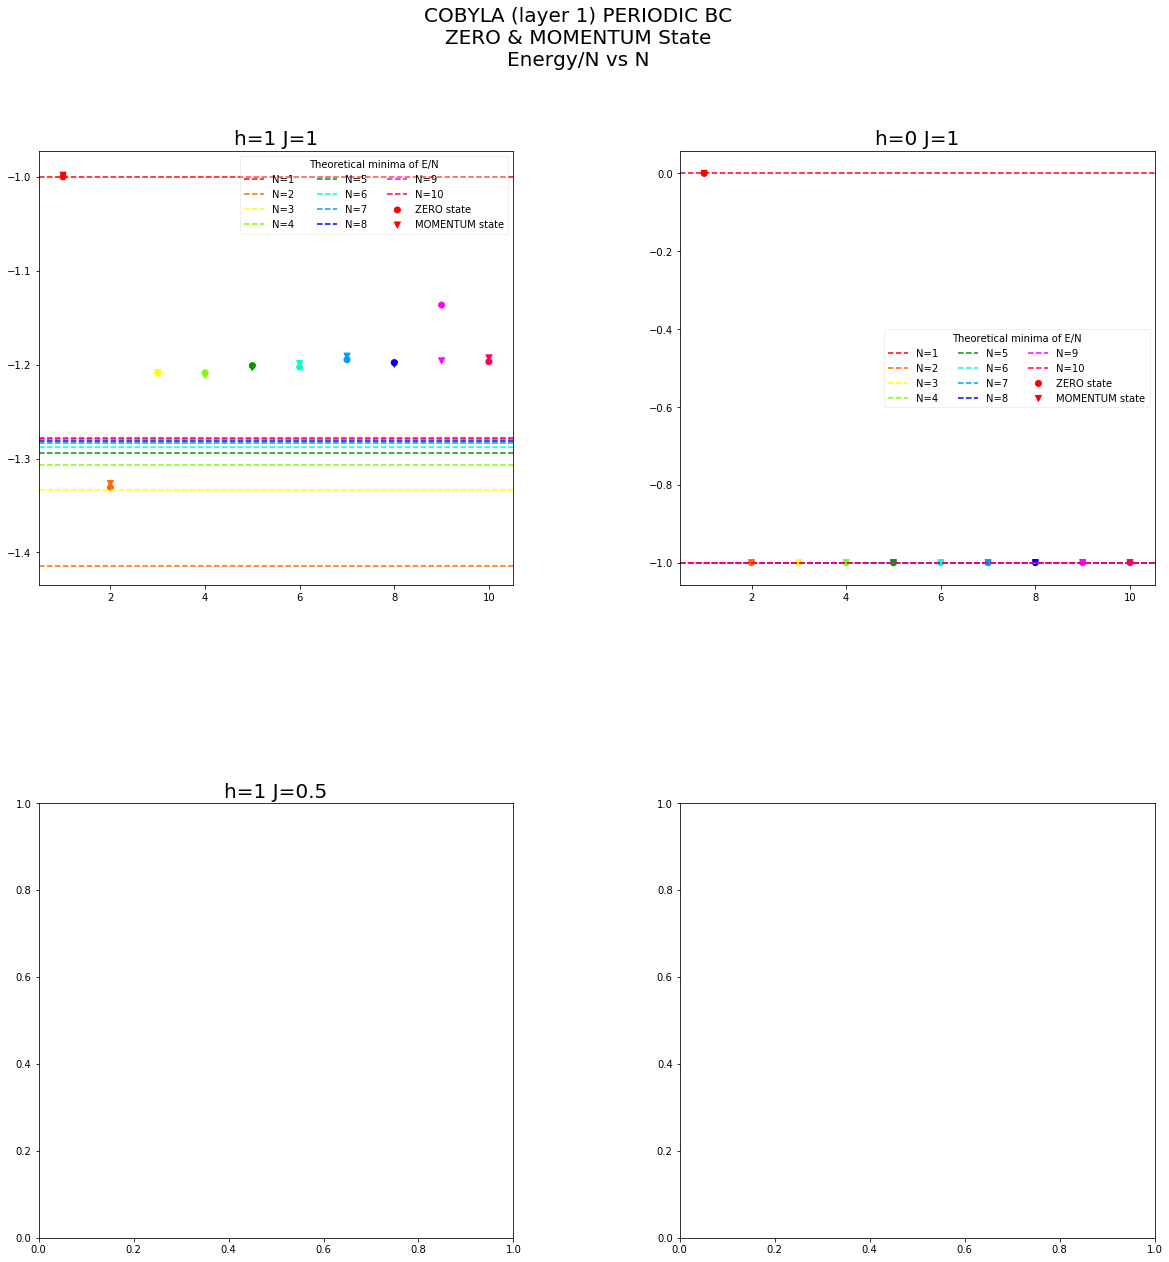

In [12]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.35)
#fig.title('COBYLA')
fig.suptitle('COBYLA (layer 1) PERIODIC BC\nZERO & MOMENTUM State\nEnergy/N vs N',fontsize=20)
x = np.linspace(1, 10, 10)

axs[0,0].title.set_text("h=1 J=1")
axs[0,0].title.set_size(20)
y_h1j1_zero = pd.Series(np.array(COB_E1_h1j1_zero_PBC))
y_h1j1_mome = pd.Series(np.array(COB_E1_h1j1_momentum_PBC))
# y3 = pd.Series(np.array(COB_E3_h1j1_zero_PBC))
# y4 = pd.Series(np.array(COB_E4_h1j1_zero_PBC))
# y5 = pd.Series(np.array(COB_E5_h1j1_zero_PBC))

axs[0,0].scatter(x,y_h1j1_zero ,marker='o',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'], label = 'ZERO state')
axs[0,0].scatter(x,y_h1j1_mome ,marker='v',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'],label = 'MOMENTUM state')
# axs[0,0].scatter(x,y3,marker='^',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# axs[0,0].scatter(x,y4,marker='8',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# axs[0,0].scatter(x,y5,marker='X',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])

l1d_1=axs[0,0].axhline(y=-1, color='#ff0000', linestyle='--',label = 'N=1')
l2d_1=axs[0,0].axhline(y=-2.82842712/2, color='#ff6600', linestyle='--',label = 'N=2')
l3d_1=axs[0,0].axhline(y=-4/3, color='#ffff00', linestyle='--',label = 'N=3')
l4d_1=axs[0,0].axhline(y=-5.22625186/4, color='#80ff00', linestyle='--',label = 'N=4 ')
l5d_1=axs[0,0].axhline(y=-6.47213595/5, color='#009900', linestyle='--',label = 'N=5')
l6d_1=axs[0,0].axhline(y=-7.72740661/6, color='#00ffcc', linestyle='--',label = 'N=6')
l7d_1=axs[0,0].axhline(y=-8.98791841/7, color='#0099ff', linestyle='--',label = 'N=7')
l8d_1=axs[0,0].axhline(y=-10.2516618/8, color='#0000ff', linestyle='--',label = 'N=8')
l9d_1=axs[0,0].axhline(y=-11.517541/9, color='#ff00ff', linestyle='--',label = 'N=9')
l10d_1=axs[0,0].axhline(y=-12.78490644/10, color='#ff0055', linestyle='--',label = 'N=10')
axs[0,0].legend(shadow=False, title="Theoretical minima of E/N", framealpha=0.3, ncol=3,fancybox=True)


axs[0,1].title.set_text("h=0 J=1")
axs[0,1].title.set_size(20)
y_h0j1_zero = pd.Series(np.array(COB_E1_h0j1_zero_PBC))
y_h0j1_mome = pd.Series(np.array(COB_E1_h0j1_momentum_PBC))
# y3_h0j1 = pd.Series(np.array(COB_E3_h0j1_zero_PBC))
# y4_h0j1 = pd.Series(np.array(COB_E4_h0j1_zero_PBC))
# y5_h0j1 = pd.Series(np.array(COB_E5_h0j1_zero_PBC))

axs[0,1].scatter(x,y_h0j1_zero ,marker='o',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'], label = 'ZERO state')
axs[0,1].scatter(x,y_h0j1_mome ,marker='v',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'],label = 'MOMENTUM state')
# axs[0,1].scatter(x,y3_h0j1,marker='^',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# axs[0,1].scatter(x,y4_h0j1,marker='8',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# axs[0,1].scatter(x,y5_h0j1,marker='X',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])

l1d_2=axs[0,1].axhline(y=0, color='#ff0000', linestyle='--',label = 'N=1')
l2d_2=axs[0,1].axhline(y=-2/2, color='#ff6600', linestyle='--',label = 'N=2')
l3d_2=axs[0,1].axhline(y=-3/3, color='#ffff00', linestyle='--',label = 'N=3')
l4d_2=axs[0,1].axhline(y=-4/4, color='#80ff00', linestyle='--',label = 'N=4')
l5d_2=axs[0,1].axhline(y=-5/5, color='#009900', linestyle='--',label = 'N=5')
l6d_2=axs[0,1].axhline(y=-6/6, color='#00ffcc', linestyle='--',label = 'N=6')
l7d_2=axs[0,1].axhline(y=-7/7, color='#0099ff', linestyle='--',label = 'N=7')
l8d_2=axs[0,1].axhline(y=-8/8, color='#0000ff', linestyle='--',label = 'N=8')
l9d_2=axs[0,1].axhline(y=-9/9, color='#ff00ff', linestyle='--',label = 'N=9')
l10d_2=axs[0,1].axhline(y=-10/10, color='#ff0055', linestyle='--',label = 'N=10')
axs[0,1].legend(shadow=False, title="Theoretical minima of E/N", framealpha=0.3, ncol=3,fancybox=True)


# axs[1,0].title.set_text("h=1 J=0")
# axs[1,0].title.set_size(20)
# y_h1j0_zero = pd.Series(np.array(COB_E1_h1j0_zero_PBC))
# y_h1j0_mome = pd.Series(np.array(COB_E1_h1j0_momentum_PBC))
# # y3_h1j0 = pd.Series(np.array(COB_E3_h1j0_zero_PBC))
# # y4_h1j0 = pd.Series(np.array(COB_E4_h1j0_zero_PBC))
# # y5_h1j0 = pd.Series(np.array(COB_E5_h1j0_zero_PBC))
# axs[1,0].scatter(x,y_h1j0_zero,marker='o',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'], label = 'ZERO state')
# axs[1,0].scatter(x,y_h1j0_mome,marker='v',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'],label = 'MOMENTUM state')
# # axs[1,0].scatter(x,y3_h1,marker='^',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# # axs[1,0].scatter(x,y4_h1,marker='8',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# # axs[1,0].scatter(x,y5_h1,marker='X',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])

# l1d_3=axs[1,0].axhline(y=-1, color='#ff0000', linestyle='--',label = 'N=1')
# l2d_3=axs[1,0].axhline(y=-2/2, color='#ff8000', linestyle='--',label = 'N=2')
# l3d_3=axs[1,0].axhline(y=-3/3, color='#ffff00', linestyle='--',label = 'N=3')
# l4d_3=axs[1,0].axhline(y=-4/4, color='#80ff00', linestyle='--',label = 'N=4')
# l5d_3=axs[1,0].axhline(y=-5/5, color='#009900', linestyle='--',label = 'N=5')
# l6d_3=axs[1,0].axhline(y=-6/6, color='#00ffcc', linestyle='--',label = 'N=6')
# l7d_3=axs[1,0].axhline(y=-7/7, color='#0099ff', linestyle='--',label = 'N=7')
# l8d_3=axs[1,0].axhline(y=-8/8, color='#0000ff', linestyle='--',label = 'N=8')
# l9d_3=axs[1,0].axhline(y=-9/9, color='#ff00ff', linestyle='--',label = 'N=9')
# l10d_3=axs[1,0].axhline(y=-10/10, color='#ff0055', linestyle='--',label = 'N=10')
# axs[1,0].legend(shadow=False, title="Theoretical minima of E/N", framealpha=0.3, ncol=3,fancybox=True)


axs[1,0].title.set_text("h=1 J=0.5")
axs[1,0].title.set_size(20)
y_h1j05_zero = pd.Series(np.array(COB_E1_h1j05_zero_PBC))
y_h1j05_mome = pd.Series(np.array(COB_E1_h1j05_zero_PBC))
# y3_h1j05 = pd.Series(np.array(COB_E1_h1j05_zero_PBC))
# y4_h1j05 = pd.Series(np.array(COB_E1_h1j05_zero_PBC))
# y5_h1j05 = pd.Series(np.array(COB_E1_h1j05_zero_PBC))
axs[1,0].scatter(x,y_h1j05_zero,marker='o',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'], label = 'ZERO state')
axs[1,0].scatter(x,y_h1j05_mome,marker='v',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'],label = 'MOMENTUM state')
# axs[1,1].scatter(x,y3_h1j05,marker='^',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# axs[1,1].scatter(x,y4_h1j05,marker='8',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# axs[1,1].scatter(x,y5_h1j05,marker='X',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])

l1d_4=axs[1,0].axhline(y=-1, color='#ff0000', linestyle='--',label = 'N=1')
l2d_4=axs[1,0].axhline(y=-2.23606798/2, color='#ff8000', linestyle='--',label = 'N=2')
l3d_4=axs[1,0].axhline(y=-3.23205081/3, color='#ffff00', linestyle='--',label = 'N=3')
l4d_4=axs[1,0].axhline(y=-4.27155841/4, color='#80ff00', linestyle='--',label = 'N=4')
l5d_4=axs[1,0].axhline(y=-5.32534307/5, color='#009900', linestyle='--',label = 'N=5')
l6d_4=axs[1,0].axhline(y=-6.38469456/6, color='#00ffcc', linestyle='--',label = 'N=6')
l7d_4=axs[1,0].axhline(y=-7.44637965/7, color='#0099ff', linestyle='--',label = 'N=7')
l8d_4=axs[1,0].axhline(y=-8.50908224/8, color='#0000ff', linestyle='--',label = 'N=8')
l9d_4=axs[1,0].axhline(y=-9.57223979/9, color='#ff00ff', linestyle='--',label = 'N=9')
l10d_4=axs[1,0].axhline(y=-10.635660441/10, color='#ff0055', linestyle='--',label = 'N=10')
axs[1,1].legend(shadow=False, title="Theoretical minima of E/N", framealpha=0.3, ncol=3,fancybox=True)

# axs[2,0].title.set_text("h=0.5 J=1")
# axs[2,0].title.set_size(20)
# y_h05j1_zero = pd.Series(np.array(COB_E1_h05j1_zero_PBC))
# y_h05j1_mome = pd.Series(np.array(COB_E1_h05j1_zero_PBC))
# # y3_h05j1 = pd.Series(np.array(COB_E3_h05j1_zero_PBC))
# # y4_h05j1 = pd.Series(np.array(COB_E4_h05j1_zero_PBC))
# # y5_h05j1 = pd.Series(np.array(COB_E5_h05j1_zero_PBC))
# axs[2,0].scatter(x,y_h05j1_zero,marker='o',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'], label = 'ZERO state')
# axs[2,0].scatter(x,y_h05j1_mome,marker='v',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'],label = 'MOMENTUM state')
# # axs[2,0].scatter(x,y3_h05j1,marker='^',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# # axs[2,0].scatter(x,y4_h05j1,marker='8',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])
# # axs[2,0].scatter(x,y5_h05j1,marker='X',color=['#ff0000','#ff6600','#ffff00','#80ff00','#009900','#00ffcc','#0099ff','#0000ff','#ff00ff','#ff0055'])

# l1d_5=axs[2,0].axhline(y=-0.5, color='#ff0000', linestyle='--',label = 'N=1')
# l2d_5=axs[2,0].axhline(y=-2.23606798/2, color='#ff8000', linestyle='--',label = 'N=2')
# l3d_5=axs[2,0].axhline(y=-3.23205081/3, color='#ffff00', linestyle='--',label = 'N=3')
# l4d_5=axs[2,0].axhline(y=-4.27155841/4, color='#80ff00', linestyle='--',label = 'N=4')
# l5d_5=axs[2,0].axhline(y=-5.32534307/5, color='#009900', linestyle='--',label = 'N=5')
# l6d_5=axs[2,0].axhline(y=-6.38469456/6, color='#00ffcc', linestyle='--',label = 'N=6')
# l7d_5=axs[2,0].axhline(y=-7.44637965/7, color='#0099ff', linestyle='--',label = 'N=7')
# l8d_5=axs[2,0].axhline(y=-8.50908224/8, color='#0000ff', linestyle='--',label = 'N=8')
# l9d_5=axs[2,0].axhline(y=-9.57223979/9, color='#ff00ff', linestyle='--',label = 'N=9')
# l10d_5=axs[2,0].axhline(y=-10.63560441/10, color='#ff0055', linestyle='--',label = 'N=10')
# axs[2,0].legend(shadow=False, title="Theoretical minima of E/N", framealpha=0.3, ncol=3,fancybox=True)

for ax in axs.flat:
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(xlabel='N qubits', ylabel='Energy/N')
    ax.yaxis.label.set_size(15)
    ax.xaxis.label.set_size(15)